# Classification problem : Multinomial Naive Bayes trained on the Dataset

In [2]:
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['agg.path.chunksize'] = 0
mpl.rcParams.update( mpl.rc_params() )
plt.rcParams.update({'font.size': 18})
#plt.rcParams.update({'text.usetex': True})
plt.rcParams.update({'text.latex.preamble': 'bold'})
plt.rc('font', family='serif')

### We load the data.

In [3]:
#We load the data
data_path = "Data/GSM3130435_egfp_unmod_1_PREPROCESSED.csv.gz"
df = pd.read_csv(data_path, compression='gzip')

In [4]:
df.head()

,Unnamed: 0,utr,0,1,2,3,4,5,6,7,...,r9,r10,r11,r12,r13,rl,Length,Selection,one-hot encoding,scaled_rl
0,120605,CCACTCGATTAACATGTTAACAACATACTCGTCCGGCCGATCAGCG...,0.000137,0.000109,0.000057,0.000033,0.000015,0.000016,0.000009,0.000009,...,0.019283,0.033252,0.033252,0.027581,0.035877,3.039939,50,Selected Data,"[[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...",-2.130922
1,11605,CAAATCATGTGCAGCCCTGGCGACCGTACTGCGGTACAAGAAAGTA...,0.000067,0.000070,0.000065,0.000048,0.000023,0.000020,0.000011,0.000011,...,0.024241,0.039457,0.039457,0.039840,0.038785,3.895109,50,Selected Data,"[[0, 1, 0, 0], [1, 0, 0, 0], [1, 0, 0, 0], [1,...",-1.600332
2,128224,GTTATACTAGAAGAAACTTGAGATTATGGAGCAGTCCGTCAAGGAC...,0.000088,0.000081,0.000059,0.000035,0.000017,0.000016,0.000009,0.000009,...,0.021591,0.028353,0.028353,0.028963,0.041985,3.334524,50,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",-1.948147
3,239107,CTTAGACAAAAACAACGCGCTTTCCAGTATGCGGAGCCTTGACGGT...,0.000078,0.000071,0.000060,0.000038,0.000025,0.000016,0.000010,0.000009,...,0.026617,0.038302,0.038302,0.032788,0.031043,3.575082,50,Selected Data,"[[0, 1, 0, 0], [0, 0, 0, 1], [0, 0, 0, 1], [1,...",-1.798893
4,59082,GTATCAAATCACGGCCAACCCGACGGAGTACCCCGCGTCGATGGTC...,0.000044,0.000045,0.000050,0.000051,0.000033,0.000026,0.000015,0.000012,...,0.033080,0.051449,0.051449,0.046052,0.036447,4.593712,50,Selected Data,"[[0, 0, 1, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...",-1.166885


### We transform our problem in a classification task.

#### First, we transform the output. 

In [5]:
df['Round MRL'] = df['rl'].apply(round)
df['Round MRL']

0         3
1         4
2         3
3         4
4         5
         ..
279995    8
279996    8
279997    8
279998    3
279999    5
Name: Round MRL, Length: 280000, dtype: int64

In [6]:
print(len(df['Round MRL'].unique()))
df['Round MRL'].unique()

13


array([ 3,  4,  5,  8,  6,  7,  2,  9,  0,  1, 10, 11, 12])

We thus obtain 13 classes. Let us observe the repartition of the classes. 

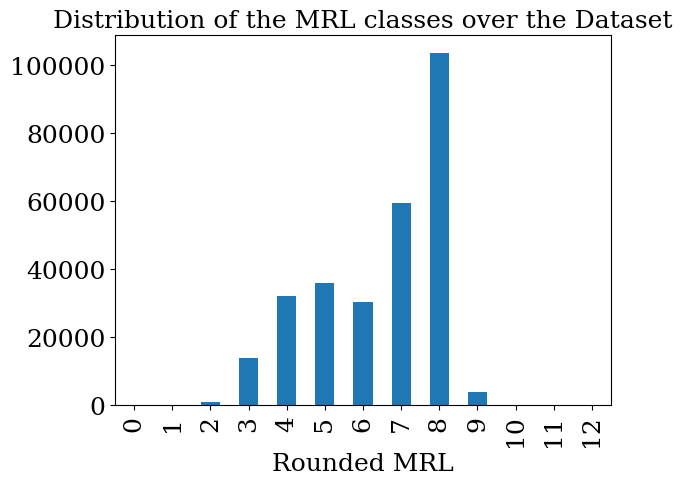

In [7]:
df['Round MRL'].value_counts().sort_index().plot.bar()
plt.title("Distribution of the MRL classes over the Dataset", fontsize = 18)
plt.xlabel("Rounded MRL")
plt.savefig("Class_imbalance.pdf", bbox_inches = "tight")
plt.show()

There is class imbalance. 

In [8]:
#Let us compute class weights 
#First, we have to compute a dictionnary with the counts per class
values = list(df['Round MRL'].unique())
counts = dict()
for value in values:
    counts[value] = df['Round MRL'].value_counts()[value]
counts

{3: 13883,
 4: 32024,
 5: 35956,
 8: 103568,
 6: 30255,
 7: 59431,
 2: 770,
 9: 3898,
 0: 11,
 1: 57,
 10: 126,
 11: 18,
 12: 3}

In [9]:
#We reshape the classes in quantitative classes
def reshape_classes(MRL):
    if (MRL <= 5):
        return 0
    elif (MRL <= 7):
        return 1
    elif (MRL > 7):
        return 2

In [10]:
df["new mrl classes"] = df["rl"].apply(reshape_classes)
df["new mrl classes"].value_counts()

2    147216
1     67546
0     65238
Name: new mrl classes, dtype: int64

In [11]:
import random
#Let us do undersampling for class 7 and 8 and oversampling for the other classes. 
df_rebalanced = df.copy()
classes = [3,4,5,8,6,7,9]
for value in values : 
    if (value == 7 or value == 8):
        indexes = list(df_rebalanced[df_rebalanced["Round MRL"] == value].index.values)        
        d = counts[value] - 40000
        random_indexes = random.choices(indexes, k = d)
        print(len(random_indexes))
        df_rebalanced.drop(random_indexes, inplace = True)
    if (value in  [3,4,5,6]):
        indexes = list(df_rebalanced[df_rebalanced["Round MRL"] == value].index.values)        
        d = counts[value] - 40000
        random_indexes = random.choices(indexes, k = d)
        df_rebalanced.append(df_rebalanced.loc[random_indexes])

df_rebalanced["Round MRL"].value_counts()

63568
19431


8     55846
7     42855
5     35956
4     32024
6     30255
3     13883
9      3898
2       770
10      126
1        57
11       18
0        11
12        3
Name: Round MRL, dtype: int64

## Case 1 : Using k-mer Counting

In [12]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=4):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [15]:
df = df.sample(frac = 1)

In [18]:
#Grid search of parameters
ks = [3, 4, 5, 6]
learning_rates = [0.1, 0.01, 0.001]
for k in ks:
    for lr in learning_rates : 
        #Creating Bags of Words
        df['words'] = df['utr'].apply(lambda x: getKmers(x, k))
        df['words'].head()
        df_text = list(df['words'])
        for item in range(len(df_text)):
            df_text[item] = ' '.join(df_text[item])
        y_data = df["new mrl classes"].values 
        cv = CountVectorizer(ngram_range=(4,4)) #ngram_range=(4,4))
        X = cv.fit_transform(df_text)
        
        #Splitting in train, validation, test
        X_test = X[:28000]
        y_test = y_data[:28000]
        X_val = X[28000:56000]
        y_val = y_data[28000:56000]
        X_train = X[56000:]
        y_train = y_data[56000:]
        
        #Define model and train
        X = cv.fit_transform(df_text)
        classifier = MultinomialNB(alpha=lr)
        classifier.fit(X_train, y_train)
        
        y_pred = classifier.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)
        print("Model k = {}; lr = {}; accuracy = {}".format(k, lr, accuracy))

Model k = 3; lr = 0.1; accuracy = 0.6962857142857143
Model k = 3; lr = 0.01; accuracy = 0.69625
Model k = 3; lr = 0.001; accuracy = 0.69625
Model k = 4; lr = 0.1; accuracy = 0.7041428571428572
Model k = 4; lr = 0.01; accuracy = 0.7041428571428572
Model k = 4; lr = 0.001; accuracy = 0.7041428571428572
Model k = 5; lr = 0.1; accuracy = 0.6968214285714286
Model k = 5; lr = 0.01; accuracy = 0.6967857142857142
Model k = 5; lr = 0.001; accuracy = 0.6968571428571428
Model k = 6; lr = 0.1; accuracy = 0.6720714285714285
Model k = 6; lr = 0.01; accuracy = 0.6690357142857143
Model k = 6; lr = 0.001; accuracy = 0.6674642857142857


### Then, we can train the model we chose with wanted parameters.

In [19]:
k_final = 0.01
lr_final = 4

In [20]:
df['words'] = df['utr'].apply(lambda x: getKmers(x))
df['words'].head()

211965    [aatt, atta, ttat, tatc, atcg, tcgg, cggt, ggt...
249845    [acca, ccac, cact, actc, ctcc, tccg, ccgc, cgc...
205321    [ccgg, cggt, ggtg, gtga, tgac, gaca, acat, cat...
156072    [ctca, tcaa, caag, aaga, agat, gatg, atgt, tgt...
22234     [taac, aaca, acac, cacc, accc, ccca, ccag, cag...
Name: words, dtype: object

In [21]:
df_text = list(df['words'])
for item in range(len(df_text)):
    df_text[item] = ' '.join(df_text[item])
y_data = df["new mrl classes"].values 


In [23]:
# Creating the Bag of Words model using CountVectorizer()
# This is equivalent to k-mer counting
# The n-gram size of 4 was previously determined by testing
cv = CountVectorizer(ngram_range=(4,4)) #ngram_range=(4,4))
X = cv.fit_transform(df_text)

In [24]:
print(X.shape)

(280000, 16384)


### We split our data into training and testing set.

In [25]:
X_test = X[:28000]
y_test = y_data[:28000]
X_val = X[28000:56000]
y_val = y_data[28000:56000]
X_train = X[56000:]
y_train = y_data[56000:]

### Multinomial NB

In [26]:
classifier = MultinomialNB(alpha=0.01)
classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.01)

In [27]:
y_pred = classifier.predict(X_test)

In [28]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 4513,  1635,   385],
       [ 1537,  3410,  1731],
       [ 1228,  1635, 11926]])

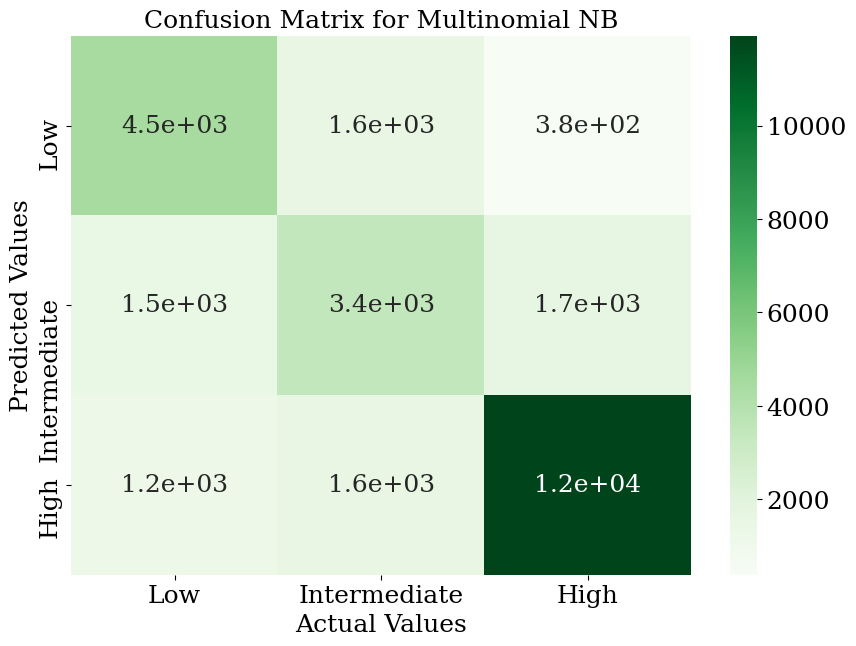

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, index = [i for i in range(3)],
                  columns = [i for i in range(3)])
plt.figure(figsize = (10,7))
plt.title("Confusion Matrix for Multinomial NB", fontsize=18)
x_ticks  = ["Low", "Intermediate", "High"]
y_ticks = ["Low", "Intermediate", "High"]
sns.heatmap(df_cm, yticklabels=y_ticks, xticklabels=x_ticks, annot=True, cmap="Greens")
plt.xlabel("Actual Values", fontsize=18)
plt.ylabel("Predicted Values", fontsize=18)
plt.savefig("Confusion_Matrix_NB.pdf")
plt.show()

In [32]:
y_test

array([2, 0, 2, ..., 2, 0, 1])

In [33]:
y_pred

array([2, 1, 2, ..., 2, 1, 1])

In [36]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.694 
precision = 0.728 
recall = 0.694 
f1 = 0.706


## Case 2 : Using tokenizers

In [29]:
e_train = df[20000:]
e_test = df[:20000]

In [47]:
def tokenize(df, col='utr', seq_len=50):
    # Dictionary returning one-hot encoding of nucleotides. 
    nuc_d = {'a':1,'c':2,'g':3,'t':4, 'n' : 5}
    
    vectors=np.empty([len(df),seq_len])
    
    for i,seq in enumerate(df[col].str[:seq_len]): 
        seq = seq.lower()
        a = np.array([nuc_d[x] for x in seq])
        vectors[i] = a
    return vectors

In [48]:
# Tokenize both training and test UTRs
seq_e_train = tokenize(e_train, seq_len=50)
seq_e_test = tokenize(e_test, seq_len=50)
seq_e_train

array([[2., 2., 3., ..., 2., 1., 2.],
       [1., 1., 4., ..., 4., 2., 1.],
       [2., 2., 3., ..., 2., 4., 1.],
       ...,
       [3., 3., 4., ..., 1., 4., 1.],
       [2., 2., 3., ..., 3., 3., 1.],
       [2., 2., 3., ..., 3., 1., 1.]])

In [49]:
# Splitting the human dataset into the training set and test set
X_train2, X_test2, y_train2, y_test2 = train_test_split(seq_e_train, 
                                                    e_train['Round MRL'], 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [53]:
classifier2 = MultinomialNB(alpha=0.01)
classifier2.fit(X_train2, y_train2)

MultinomialNB(alpha=0.01)

In [54]:
y_pred2 = classifier2.predict(X_test2)

In [55]:
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test2, y_pred2)

print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.379 
precision = 0.144 
recall = 0.379 
f1 = 0.208


/Users/mariehuynh/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN

In [58]:
#We divide the test set between training (90%) and testing set (10%)
df_test = df.iloc[:28000]
df_train = df.iloc[28000:]


In [60]:
import ast
#All one hot encodings are saved as strings of lists, so we convert them to np.array
X_train = df_train["one-hot encoding"].apply(ast.literal_eval)
y_train = df_train["rl"]

In [61]:
X_train = [np.array(x) for x in X_train]
X_train = np.array(X_train)
X_train.shape

(252000, 50, 4)

In [63]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
model.fit(X_train,y_train)


ValueError: Found array with dim 3. Estimator expected <= 2.